In [24]:
import spacy
import random
import jsonlines
from spacy.training import Example
from sklearn.metrics import classification_report, precision_recall_fscore_support
import os
import matplotlib.pyplot as plt
import numpy as np

In [25]:
# Load the dataset
data = []
with jsonlines.open('dataset.jsonl', 'r') as reader:
    for line in reader:
        data.append(line)

In [26]:
# Shuffle the dataset to randomize the order
random.shuffle(data)

In [27]:
# Function to adjust entity spans according to SpaCy's token boundaries
def adjust_entity_spans(doc, entities):
    adjusted_entities = []
    for start, end, label in entities:
        span = doc.char_span(start, end, label=label)
        if span is not None:
            adjusted_entities.append((span.start_char, span.end_char, label))
    return adjusted_entities

In [28]:
# Convert the dataset to SpaCy format and adjust entity spans
def convert_data_for_spacy(data, nlp):
    spacy_format = []
    for item in data:
        text = item['text']
        doc = nlp.make_doc(text)
        entities = adjust_entity_spans(doc, item['label'])
        spacy_format.append((text, {"entities": entities}))
    return spacy_format

In [29]:
# Convert the entire data to SpaCy format
test_data_spacy = convert_data_for_spacy(data, spacy.load("pt_core_news_sm"))

In [30]:
# Evaluate each model
models = ["model_sm", "model_md", "model_lg"]
results = {}

In [31]:
for model in models:
    # Load the model
    nlp = spacy.load(f"3VA/{model}")
    
    true_labels = []
    pred_labels = []
    
    for text, annotations in test_data_spacy:
        doc = nlp(text)
        pred_entities = [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]
        true_entities = annotations["entities"]

        # Create a dictionary to store the predicted and true labels with their spans
        pred_dict = {(start, end): label for start, end, label in pred_entities}
        true_dict = {(start, end): label for start, end, label in true_entities}

        # Union of all spans (keys) from both true and predicted dictionaries
        all_spans = set(pred_dict.keys()).union(set(true_dict.keys()))

        # Compare the labels based on spans
        for span in all_spans:
            true_labels.append(true_dict.get(span, "O"))  # "O" represents no entity in the true labels
            pred_labels.append(pred_dict.get(span, "O"))  # "O" represents no entity in the predicted labels

    # Calculate precision, recall, and F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted')
    results[model] = {'precision': precision, 'recall': recall, 'f1': f1}

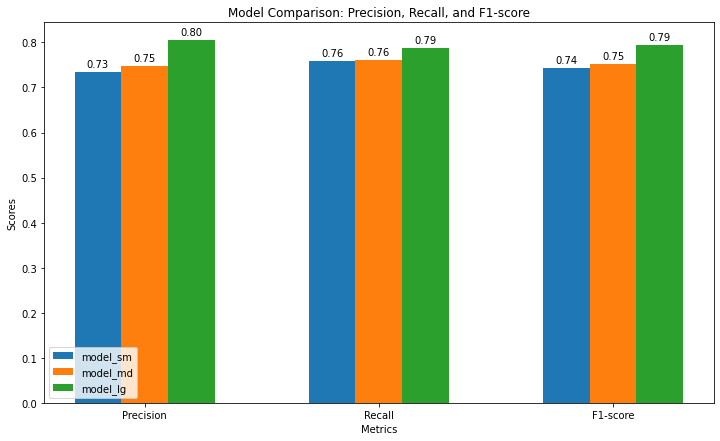

In [35]:
# Plot the results
labels = ['Precision', 'Recall', 'F1-score']
x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 7))

for i, model in enumerate(models):
    bars = ax.bar(x + i * width, [results[model]['precision'], results[model]['recall'], results[model]['f1']], width, label=model)
    
    # Annotate bars with their values
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Model Comparison: Precision, Recall, and F1-score')
ax.set_xticks(x + width)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

In [36]:
# Print the results
print("\nModel Evaluation Results:")
for model in models:
    print(f"\n{model}:")
    print(f"  Precision: {results[model]['precision']:.4f}")
    print(f"  Recall: {results[model]['recall']:.4f}")
    print(f"  F1-score: {results[model]['f1']:.4f}")


Model Evaluation Results:

model_sm:
  Precision: 0.7340
  Recall: 0.7580
  F1-score: 0.7432

model_md:
  Precision: 0.7485
  Recall: 0.7600
  F1-score: 0.7521

model_lg:
  Precision: 0.8045
  Recall: 0.7869
  F1-score: 0.7939


Avaliação dos Modelos

O model_sm apresenta uma precisão e um recall bastante equilibrados, com um F1-score relativamente bom. No entanto, comparado aos modelos maiores, ele tem um desempenho um pouco inferior.

O model_md mostra uma leve melhoria em precisão e recall em relação ao model_sm. O F1-score também é um pouco melhor, o que indica uma performance um pouco mais robusta e equilibrada.

O model_lg se destaca com as melhores métricas entre os três modelos. A precisão e o recall são significativamente maiores, e o F1-score é o melhor de todos. Isso sugere que o model_lg é o mais eficaz para a tarefa de reconhecimento de entidades, possivelmente devido ao seu maior tamanho e complexidade.

Conclusão
O modelo model_lg demonstra o melhor desempenho geral, com precisão, recall e F1-score mais altos, indicando que ele é o mais capaz de identificar e classificar as entidades no seu conjunto de dados. Os modelos menores (model_sm e model_md) ainda são eficazes, mas a performance deles é um pouco inferior comparada ao modelo maior. Se o custo computacional não for um problema, o model_lg é a melhor escolha para a tarefa.